# Sentiment Analysis Using Neural Networks

Aaron Balke

S# 011005116

# Presentation

https://youtu.be/2G2fAF3lKGc

# Part I: Research Question

## A1. Question

For this assessment the research question is, "Can a Nueral Network accurately classify a review as positive sentiment or negative sentiment using the provided dataset?"

## A2. Goals

Classifying review sentiment requires a neural network in order to process complex natural language. If we are able to accurately classify sentiment, having a model that correctly predict new data with a 75% or greater accuracy, we could add a new sentiment feature to our dataset, which can be used in future analysis. The processing of this data is a stepping stone to future analysis and insights for our business.

## A3. Neural Network

A Neural Network is a type of machine learning model that uses nodes/nuerons to assist in complicated, multivariable predictions and classifications. For our analysis, we will be using a Recurrent Neural Network (RNN). An RNN is commonly used for sequential data problems, such as natural language processing, since it finds patterns between current and prior inputs. This is as opposed to CNNs which are used for spacial data such as images. (IBM)

# Part II: Data Preparation

## B1. Exploratory Data Analysis

### Data Preprocessing
1. Load Libraries and Data
2. Add Source Column to tell which CSV the record came from
3. Create a Merged Dataframe

In [1]:
# Python Libraries
import re
import math
from collections import Counter

# The usual Data Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Sklearn Libraries will be used to evaluate model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics

# Emoji Library
!pip install emoji
import emoji

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Import Data
df_amaz = pd.read_csv('../data/amazon_cells_labelled.txt',
                      delimiter="\t",
                      names=['Review','Type'],
                      encoding='utf8'
                      )
df_imdb = pd.read_csv('../data/imdb_labelled.txt',
                      delimiter="\t",
                      names=['Review','Type'],
                      encoding='utf8'
                      )
df_yelp = pd.read_csv('../data/yelp_labelled.txt',
                      delimiter="\t",
                      names=['Review','Type'],
                      encoding='utf8'
                      )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
np.random.seed(seed=100)
tf.random.set_seed(100)

In [3]:
# Add Source Feature to Dataframes
df_amaz['Source'] = "Amazon"
df_imdb['Source'] = "Imdb"
df_yelp['Source'] = "Yelp"

# Merge Dataframes
df_merged = pd.concat([df_amaz, df_imdb, df_yelp], ignore_index=True, sort=False)

### Unusual Characters

We have to know which characters are included in our dataset, the differences between unicode and ascii can cause computing problems, particularly in lower level computing and machine learning. Additionally, some characters are not obvious, such as the difference between a tab character and a newline, which both are whitespace characters.

In [4]:
# Checks for Unusual Characters & Emojis
# Sets are used for element uniqueness

def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)

unique_chars = []
emojis = set()

for review in df_merged.Review:
    emojis.add(extract_emojis(review))
    review_chars = list(set(review))
    unique_chars = list(set(unique_chars + review_chars))

unique_chars.sort()

unusual_chars = []
unusual_chars_dec = []

for char in unique_chars:
    if re.match('[^A-Za-z\d!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ]+', char):
        unusual_chars.append(char)
        unusual_chars_dec.append(ord(char))

print("Unique Characters: ", *unique_chars, sep=" ") 
print("\nUnusual Characters:", *unusual_chars, sep=" ")
print(f"\nUnusual Characters (Decimal Values):\n", *unusual_chars_dec, sep=" ")
print(f"\nNumber of Unique Emojis:\n {len(emojis) - 1}")

Unique Characters:  	 
   ! " # $ % & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z [ ] a b c d e f g h i j k l m n o p q r s t u v w x y z    å é ê

Unusual Characters: 	 
    å é ê

Unusual Characters (Decimal Values):
 9 10 133 150 151 229 233 234

Number of Unique Emojis:
 0


Unusual Unicode Characters include:
1. 2 whitespace chars '\t' and '\n'
2. Misc Next Line & Guarded Area Chars & '\x85', '\x96', '\x97'
3. Non-English Chars 'å', 'é', 'ê'

There are no emojis in the text

We will next remove all punctuation and unusual characters

In [5]:
# Keep Only Alpha Characters and Spaces
df_merged.Review.replace('[^A-Za-z ]+', '', regex=True, inplace=True)

### Set Lowercase

This is easier to complete now rather than after other preparation and tokenization.

In [6]:
# For Each Review in DataFrame, Run String Method Lower on it
df_merged.loc[:, 'Review'] = df_merged.Review.apply((lambda x: x.lower()))

### Vocabulary Size

The vocabulary size is important for our RNN model, each unique word has to be tokenized for processing by the Recurrent Neural Network, and we will have to define the dimensionality of the data for the model to process all words.

Note: This is pulled almost directly from the Datacamp NLP Resource, see Sources.

In [7]:
vocab = []
max_review_words = [0,0]

for i, review in enumerate(df_merged.Review):
    review_words = word_tokenize(review)
    
    # Get Index, and Size of Largest Review, by Words
    if len(review_words) > max_review_words[1]:
        max_review_words[0] = i
        max_review_words[1] = len(review_words)
    vocab = vocab + review_words
    
vocab_counter = Counter(vocab)

print(f"Vocabulary Size: {len(vocab_counter)} Unique Words")

Vocabulary Size: 5301 Unique Words


### Embedding Size

According to Google's Developer Blog, for Natural Language Processing, the embedding size should be the sqrt of the sqrt of the vocabulary length. Embedding Size is used to define the output dimension of the Embedding Layer, which needs to be small enough to allow following layers to calculate effectively, without unnecessary data.

In [8]:
embedding_length = round(len(vocab_counter) ** 0.25)
print(f"Embedding Length: {embedding_length}")

Embedding Length: 9


### Maximum Sequence Length

Should be length of longest sentence, in words, other sentences will be padded to this length, which is why we need the value. (Brownlee)

In [9]:
# Check Vocabulary Size for 
print(f"The Longest Review (Index: {max_review_words[0]}) has: {max_review_words[1]} Words")
print(f"The Maximum Sequence Length should be: {max_review_words[1]}")

The Longest Review (Index: 1136) has: 1282 Words
The Maximum Sequence Length should be: 1282


### Remove Stop Words

Stop Words are common words that will not provide substanial value to the model. They need to be removed to limit noise.

In [10]:
# Initiate list of stop words
stop = stopwords.words('english')

# For word in review, if the word is in stop words remove
def remove_stops(review):
    words = [word for word in review.split() if word not in stop]
    return " ".join(words)

# For each review in DataFrame run remove_stops function
df_merged.loc[:, 'Review'] = df_merged.Review.apply((lambda review: remove_stops(review)))

### Run Longest Word Procedures Again

Run Maximum sequence length again, this time without stop words.

In [11]:
# Vocabulary Size
vocab = []
max_review_words = [0,0]

for i, review in enumerate(df_merged.Review):
    review_words = word_tokenize(review)
    
    # Get Index, and Size of Largest Review, by Words
    if len(review_words) > max_review_words[1]:
        max_review_words[0] = i
        max_review_words[1] = len(review_words)
    vocab = vocab + review_words

vocab_counter = Counter(vocab)
print(f"Vocabulary Size: {len(vocab_counter)} Unique Words")


# Embedding Size
embedding_length = round(len(vocab_counter) ** 0.25)
print(f"Embedding Length: {embedding_length}")

# Maximum Sequence Length
print(f"After Removing Stopwords, The Longest Review (Index: "
      f"{max_review_words[0]}) has: {max_review_words[1]} Words")
print(f"After Removing Stopwords, The Maximum Sequence Length should be: "
      f"{max_review_words[1]}")

Vocabulary Size: 5179 Unique Words
Embedding Length: 8
After Removing Stopwords, The Longest Review (Index: 1136) has: 686 Words
After Removing Stopwords, The Maximum Sequence Length should be: 686


# B2. Tokenization Process

The tokenization process splits the complicated reviews into individual chunks of information that can be compared across reviews. In our case these are words, that are converted into positive integers to be fed into the model. Our model will require sequences of fixed size, and only positive values. The Tokenizer exports only positive integers by default. Padding will be used to make all sequences the same fixed length, and is required since the Neural Network requires same shape data. The Tokenizer and padding preprocessing objects are provided by the Tensorflow library.

In [12]:
# Train, Validation and Test Split (Train 60%, Validate 20%, Test 20% ), See B5 for details
X_train, X_test, y_train, y_test = train_test_split(
    df_merged['Review'],
    df_merged['Type'],
    test_size=0.4,
    random_state=100
)
X_validation, X_test, y_validation, y_test = train_test_split(
    df_merged['Review'],
    df_merged['Type'],
    test_size=0.5,
    random_state=100
)

In [13]:
# Create & Fit Tokenizer Object to training data
tokenizer = Tokenizer(num_words=len(vocab_counter), oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Convert Reviews into Sequences of Token Ids
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validation_sequences = tokenizer.texts_to_sequences(X_validation)

# B3. Padding

Our model will require all sequences to be the same fixed length. Our longest sequence will be our chosen length, as to not truncate any data. All other sequences will be padded to match the length of the longest sequence. The padding will occur before the sequence. This is the default, and with no truncating, does not provide a different result compared to padding afterwards (Tensorflow).

In [14]:
# Training has longest review, need to calc first to get same shape for testing
training_padded = pad_sequences(training_sequences)
testing_padded = pad_sequences(testing_sequences, maxlen=training_padded.shape[1])
validation_padded = pad_sequences(validation_sequences, maxlen=training_padded.shape[1])

# The first Training Sequence, Padded
print(*training_padded[0])

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

# B4. Categories and Activation Function

The output values will be a discrete binary choice. 0: Bad Review, 1: Good Review. 
Because of this the final dense layer will have a single node, and a sigmoid activation function. The sigmoid function will limit values to between 0 and 1. Representing a probability of being a Good Review.

If the output was categorical, the number of nodes would match the amount of categories. Additionally, a softmax activation function would be used, providing a probability for each node/category. (Datacamp)

# B5. Data Preparation

Previously to prepare the dataset:
1. Emojis, and Unusual characters are removed from the dataset
2. Dataset is converted to lowercase
3. Stop Words are removed from the dataset
4. Split Data:
    1. A Training Split: This is the largest split and is used to train the supervised model to classify reviews as either positive or negative sentiment.
    2. A Validation Split: This is a split used to evaluate the accuracy and loss of each epoch. This allows us to see when the model is overfitting or underfitting.
    3. A Testing Split: This is the final split used after the model has been trained. This works as the "Real World Data" that the model has not seen yet, and will allow us to evaluate accuracy, accurately. The validation split cannot be used since it was used to guide the model, and will have a higher score than the Test Split.

    I decided to used a 60% Training, 20% Validation and 20% Testing split. Based on research, for the size of our dataset, a validation and testing size of 10% would cause to much variance inside those sections, on the opposite side, a training split of 50% would begin to cause to much variance on that side. So a split between 50%/25%/25% and 80%/10%/10% seemed optimal. 
5. Words are tokenized in the datasets
6. Sequences are Padded to make all sequences the same shape

## B6. Data Export

In [15]:
# Export Data, prior to splits for ease of use
df_merged.to_csv('d213_task2_clean.csv')

# Part III: Network Architecture

## C1. Initialize Model

In [16]:
# Use this to clear model during testing
keras.backend.clear_session()

# Use this to load previously saved model
# model = keras.models.load_model('d213_task2_model.h5')

In [17]:
# Model Dimensional Info
n_cols = training_padded.shape[1]
e_dim = math.floor(len(word_index)**0.25)

# Create Architecture of Model
model = Sequential()
model.add(Embedding(len(word_index)+1, e_dim, input_length=n_cols))
model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 686, 7)            27454     
                                                                 
 global_average_pooling1d (G  (None, 7)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 48        
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 27,509
Trainable params: 27,509
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile Model
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

# C2. & C3. Model Architecture

## Building

A Sequential Model was chosen since there would be one input and one output with a linear topology. 4 Layers were chosen, I experimented with more and less and found this amount to be optimal.

### The Embedding Layer
The embeddings layer is first used to turn integers into dense fixed-size vectors for the next layers to accurately use.

The first parameter defines the input dimension, in our case this is the vocabulary size.

The second parameter defines the output dimension, according to Google this should be ~ the sqrt of the sqrt of the vocabulary size (See previous Embedding Size section).

The final parameter is the input length, which defines the size of each sequence. This is the length of the longest review in our dataset, in words, which all reviews should match since we padded them.

### GlobalAveragePooling1D

The GlobalAveragePooling1D layer converts the embedding layer output, a 3D Tensor DataType, to a 2D Tensor Datatype. This 'flattens' the data. Flattening the data removes unnecessary data from the model, allowing the next layers to calculate more effectively.

### Dense 1

The first Densely connected layer has 6 nodes, I experimented with more and less and found 6 to be optimal. The Relu activation function is used to keep a 'strong' model. other functions on this layer would cause a vanishing gradient problem.

### Dense 2

The final Dense layer converts the multiple nodes into 1 final binary node. Since the desired output is a binary "Good Review?" question, we just need probability values between 0 and 1. This is the role of the sigmoid function. If this was a categorical dataset with more than a yes/no question, a softmax function would be used, with the number of layers equaling the number of choices.

## Compiling

The model is compiled using:

ADAM Optimizer: Adam is used to automate most of the optimization, including choosing a learning rate. It is a good option for noisy datasets, such as ours. (Cornell)

Binary Crossentropy: Crossentrophy Loss Functions are used when building probabilistic distribution models, such as categorical or binary. In our situation we are using binary crossentrophy since our model output is binary. If we had a categorical output we would use categorical crossentrophy. (Wikipedia)

Accuracy is used to evaluate the model, since with accuracy we can not only compare the training data, but the testing as well. This allows us to see if the model is just bad or is overfitting the training data, lossing accuracy on testing data.

Stopping Criteria: A Stopping Criteria of Validation Accuracy is used, since from my loss function it is obvious we are not having an overfitting problem. A high patience value of 20 was chosen, this was due to inconsistencies with a lower patience value of 10 and below. Sometimes, the model has trouble, "getting up and going". See D1 for a more indepth explination.

## Fitting

75 Epochs are used in our model to get the highest accuracy while avoiding overfitting. See Stopping Criteria for more info on the model fitting process.

In [19]:
early_stopping_monitor = EarlyStopping(monitor="val_accuracy", patience=20)

history = model.fit(training_padded, y_train, epochs=75,
                    callbacks=[early_stopping_monitor],
                    validation_data = (validation_padded, y_validation)
                   )

Epoch 1/75
52/52 [==============================] - 2s 12ms/step - loss: 0.6933 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 2/75
52/52 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6930 - val_accuracy: 0.5095
Epoch 3/75
52/52 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 4/75
52/52 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5146 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 5/75
52/52 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 6/75
52/52 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 7/75
52/52 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 8/75
52/52 [=

# D1. Stopping Criteria

I did use a stop criteria with my model and experimented with a patience range of 1-10 epochs; however, I found it did not consistently get past the first 10 epochs to where the model actually learned. If it was able to get past these epochs it would have been useful for stopping ~epoch 60 before accuracy stopped increasing. My network is not very dense, which means it requires many epochs to learn. If my model was denser, I may be able to take advantage of the stop critera more effectively. Additionally, with a larger dataset, the inconsistencies could be limited. I chose to use validation accuracy has my stop criteria metric, since validation loss was not a concern, the model is not overfitting.

# D2. Fitness (Overfitting/Underfitting)

Based on my parameter tuning, I believe I have a model just shy of overfitting. According to the Tensorflow documentation (t1), Validation loss would begin to level out and then rise at the point of overfitting, we are just beginning to level out with 75 epochs. Additionally, accuracy is still slowly rising. It is important to note the sparatic jumps in validation accuracy between 0 - 40 epochs. Some sources claim this is proof of overfitting, and others claim this can be from random noise in the data. After taking into account the entire models performance, and the fact that the modeling can be inconsistent, I believe these are caused from random noise when the model was still 'young' and could not properly classify. The validation accuracy usually has an increase after 40 epochs, regardless of the random weights state. This shows it was still learning and the validation loss did not begin to stagnate. Further elaboration is available in the Functionality section. If overfitting did become a problem, the stop criteria would end the fitting before it became too large of a problem.

# D3. Visualizations

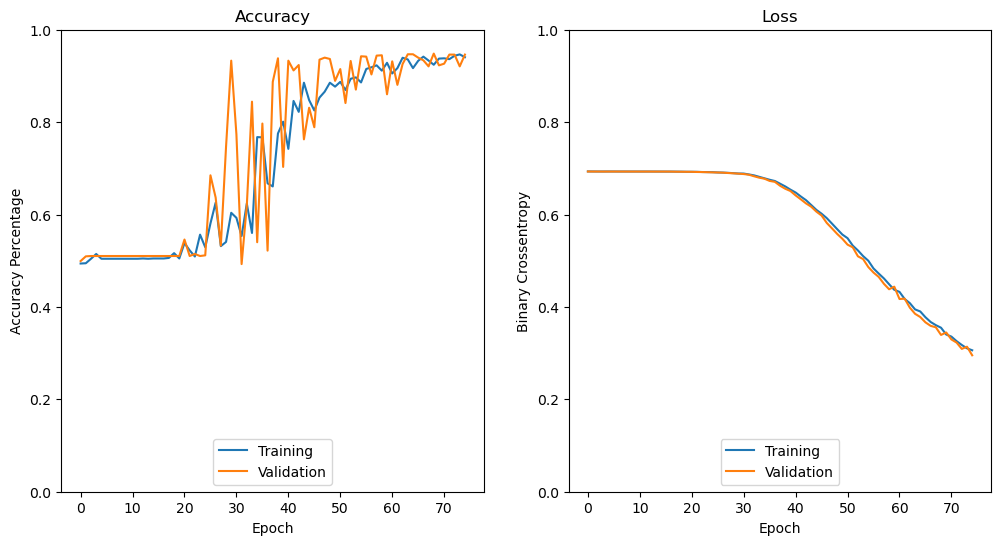

In [20]:
# plot parameters
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs=range(len(accuracy))

fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, figsize=(12, 6))

# Accuracy Plot
ax1.plot(epochs, accuracy)
ax1.plot(epochs, validation_accuracy)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy Percentage")
ax1.set_title('Accuracy')
ax1.set_ylim(0, 1)
ax1.legend(['Training', 'Validation'], loc='lower center')

# Loss Plot
ax2.plot(epochs, loss)
ax2.plot(epochs, validation_loss)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Binary Crossentropy")
ax2.set_title('Loss')
ax2.set_ylim(0, 1)
ax2.legend(['Training', 'Validation'], loc='lower center')

plt.show()

## D4. Predictive Accuracy

We can see from the above plots, the model has an accuracy nearing 100% for both the Training and Validation data, but these datasets have been supervised. To check the actual predictive accuracy of the dataset, we will run a prediction on new data the model has not seen, and evaluate the accuracy of the predicted data.

43/43 [==============================] - 0s 1ms/step


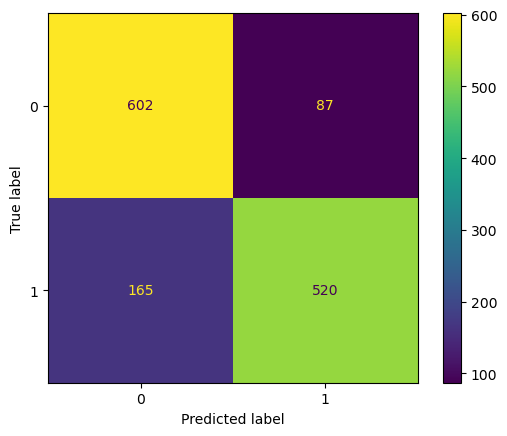

Accuracy: 0.82
Precision: 0.86
Sensitivity (Recall): 0.76
Specificity: 0.87
F-score: 0.8


In [21]:
# Predict Labels
y_pred = model.predict(testing_padded).round()

# Plot Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

# All Confusion Matrix Metrics
print(f'Accuracy: {round(metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(metrics.precision_score(y_test, y_pred),2)}')
print(f'Sensitivity (Recall): {round(metrics.recall_score(y_test, y_pred),2)}')
print(f'Specificity: {round(metrics.recall_score(y_test, y_pred, pos_label=0),2)}')
print(f'F-score: {round(metrics.f1_score(y_test, y_pred),2)}')

# Part V: Summary and Recommendations

## E. Saved Model

In [22]:
# Save Model to h5 File
model.save('d213_task2_model.h5')

## F. Functionality

After running multiple models and changing random states I believe this model is semi-functional. My reasoning is it does provide an 83% accuracy on new data it hasn't seen before (Test Data). However, I do believe their are a few things that can be done to make it more effective.
First, if more layers were added, we could lower the number of epochs it takes to get to 83%, with more nodes we should be able to lower the number of epochs.
Secondly, after testing different random states of the train_test_split, it became very clear the dataset has a lot of noise. Some splits made the model learn rapidly, achieving 80% accuracy after 2-3 epochs, and then overfitting, other times it took more then 75 epochs to reach 80% accuracy. Depending on how the data is split, it can very much effect the training/fitting effectiveness. We also can see the model is noisy from the random jumps in accuracy from the validation data. There will be random epochs where the validation accuracy is 90%+, then it drops back to 40-50%.

## G. Recommendation

For the next course of action, I do believe the model can be used effectively to classify good and bad reviews. However, I believe long term in order to make a more effective model a larger dataset should be used. With a larger dataset, the problems mentioned under Functionality should be removed.

## I. Web Sources

How to extract all the emojis from text? (n.d.). Stack Overflow. Retrieved January 2, 2024, from https://stackoverflow.com/questions/43146528/how-to-extract-all-the-emojis-from-text

Zach. (2021, August 19). How to Use Pandas apply() inplace. Statology. https://www.statology.org/pandas-apply-inplace/

Natural Language Processing - Tokenization (NLP Zero to Hero - Part 1). (n.d.). Www.youtube.com. Retrieved January 2, 2024, from https://youtu.be/fNxaJsNG3-s?si=9i2SHMXQ1JmeZdzk

Sequencing - Turning sentences into data (NLP Zero to Hero - Part 2). (n.d.). Www.youtube.com. Retrieved January 2, 2024, from https://youtu.be/r9QjkdSJZ2g?si=pkrLMRVY_fWAQUzy

Training a model to recognize sentiment in text (NLP Zero to Hero - Part 3). (n.d.). Www.youtube.com. Retrieved January 2, 2024, from https://youtu.be/Y_hzMnRXjhI?si=04EM7nKNCDPG270O

Python Remove Key from Dictionary – How to Delete Keys from a Dict. (2023, February 22). FreeCodeCamp.org. https://www.freecodecamp.org/news/python-remove-key-from-dictionary/

Khanna, C. (2021, February 10). Text pre-processing: Stop words removal using different libraries. Medium. https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

Why is the validation accuracy fluctuating? (n.d.). Cross Validated. Retrieved January 2, 2024, from https://stats.stackexchange.com/questions/255105/why-is-the-validation-accuracy-fluctuating

Train loss is decreasing, but accuracy remain the same. (2021, January 17). Hugging Face Forums. https://discuss.huggingface.co/t/train-loss-is-decreasing-but-accuracy-remain-the-same/3244

Validation loss and accuracy has a lot of “jumps.” (n.d.). Stack Overflow. Retrieved January 2, 2024, from https://stackoverflow.com/questions/75274978/validation-loss-and-accuracy-has-a-lot-of-jumps

Why my network needs so many epochs to learn? (n.d.). Data Science Stack Exchange. RetrievedJanuary 2, 2024, from https://datascience.stackexchange.com/questions/53033/why-my-network-needs-so-many-epochs-to-learn

Tensorflow. (2017). Explore overfitting and underfitting  |  TensorFlow Core  |  TensorFlow. TensorFlow. https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

machine learning - Why binary_crossentropy and categorical_crossentropy give different performances for the same problem? (n.d.). Stack Overflow. https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances

Kingma, D. P., & Ba, J. (2014, December 22). Adam: A Method for Stochastic Optimization. ArXiv.org. https://arxiv.org/abs/1412.6980

What is the difference between test set and validation set. (2011, November 28). What is the difference between test set and validation set? Cross Validated. https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set

Tokuç, A. A. (2021, January 14). Splitting a Dataset into Train and Test Sets | Baeldung on Computer Science. Www.baeldung.com. https://www.baeldung.com/cs/train-test-datasets-ratio

Why is the result changing every time I run my TensorFlow model in my code? (n.d.). Stack Overflow. Retrieved December 15, 2023, from https://stackoverflow.com/questions/76325816/why-is-the-result-changing-every-time-i-run-my-tensorflow-model-in-my-code

## J. Other Sources

Google. Introducing TensorFlow Feature Columns. (n.d.). https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

Brownlee, J. How to Use Word Embedding Layers (2017, October 3). How to Use Word Embedding Layers for Deep Learning with Keras. Machine Learning Mastery. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

IBM. (2023). What are Recurrent Neural Networks? | IBM. Www.ibm.com. https://www.ibm.com/topics/recurrent-neural-networks